In [64]:
%pylab inline
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
from glob import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sys

Populating the interactive namespace from numpy and matplotlib


## Globals

In [65]:
ttw = np.arange(0,45)
asp = np.arange(45,57)
groups = [ttw, asp]
topfile = 'act_site.pdb'
feat = coor.featurizer(topfile)

In [66]:
traj_list = glob('aligned/*as[12]-2ns-aligned.dcd')
inp = coor.source(traj_list, feat)
print('number of trajectories = ',inp.number_of_trajectories())
print('trajectory length = ',inp.trajectory_length(0))
print('trajectory time step = ',1000 / (inp.trajectory_length(0)),'ps')

('number of trajectories = ', 200)
('trajectory length = ', 2000)
('trajectory time step = ', 0, 'ps')


## Add features

In [67]:
all_atoms = np.arange(1, 58, 1)
hydrogen = np.array([1, 4, 6, 7, 12, 17, 22, 24, 25, 28, 31, 33, 37, 39, 41, 43, 47, 51, 52])
heavy_atoms = np.setdiff1d(all_atoms, hydrogen)
aromatic = np.array(range(8,21)+range(31,43))
arom_join = np.array([8,9,14,29,30,35])
arom_nonjoin = np.setdiff1d(aromatic, arom_join)

# joint is the flexible bit of the molecule where the substrate binds to the enzume.  
# Inpsection of some of the 
joint = np.array([15, 17, 19, 20, 22, 25, 28, 29, 34])
angles = pickle.load(open('act_site_ang.p', 'rb'))-1
bonds = pickle.load(open('act_site_bond.p', 'rb'))-1
dihedrals = pickle.load(open('act_site_dihe.p', 'rb'))-1

def select_coords(coords, atom_list):
    new_coords = []
    for coord in coords:
        if np.in1d(coord, atom_list).all():
            new_coords.append(list(coord))
    return new_coords

joint_angles = select_coords(angles, joint)
joint_dihedrals = select_coords(dihedrals, joint)
joint_bonds = select_coords(bonds, joint)

feat.add_dihedrals(joint_dihedrals, cossin=True, periodic=True)
# feat.add_angles(joint_angles, cossin=True)
# feat.add_distances(joint_bonds)
print(inp.dimension())
print(inp.describe())

12
['Feature reader with following features', 'DIH: COS(TTW 39 CZ3 15 -  TTW 39 CH2 19 - TTW 39 NT 20 - TTW 39 CI2 22)', 'DIH: SIN(TTW 39 CZ3 15 -  TTW 39 CH2 19 - TTW 39 NT 20 - TTW 39 CI2 22)', 'DIH: COS(TTW 39 CZ2 17 -  TTW 39 CH2 19 - TTW 39 NT 20 - TTW 39 CI2 22)', 'DIH: SIN(TTW 39 CZ2 17 -  TTW 39 CH2 19 - TTW 39 NT 20 - TTW 39 CI2 22)', 'DIH: COS(TTW 39 CH2 19 -  TTW 39 NT 20 - TTW 39 CI2 22 - TTW 39 C1 25)', 'DIH: SIN(TTW 39 CH2 19 -  TTW 39 NT 20 - TTW 39 CI2 22 - TTW 39 C1 25)', 'DIH: COS(TTW 39 NT 20 -  TTW 39 CI2 22 - TTW 39 C1 25 - TTW 39 CW1 28)', 'DIH: SIN(TTW 39 NT 20 -  TTW 39 CI2 22 - TTW 39 C1 25 - TTW 39 CW1 28)', 'DIH: COS(TTW 39 CI2 22 -  TTW 39 C1 25 - TTW 39 CW1 28 - TTW 39 CW2 29)', 'DIH: SIN(TTW 39 CI2 22 -  TTW 39 C1 25 - TTW 39 CW1 28 - TTW 39 CW2 29)', 'DIH: COS(TTW 39 CI2 22 -  TTW 39 C1 25 - TTW 39 CW1 28 - TTW 39 CW8 34)', 'DIH: SIN(TTW 39 CI2 22 -  TTW 39 C1 25 - TTW 39 CW1 28 - TTW 39 CW8 34)']


## TICA

### Plot TICA component for different TICA lag-times

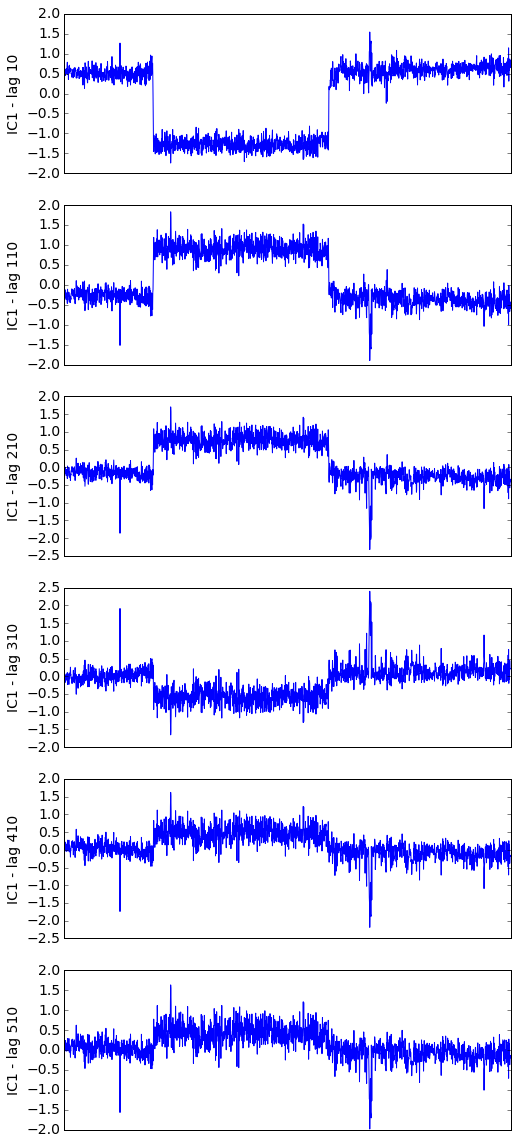

In [68]:

matplotlib.rcParams.update({'font.size': 14})
dt = 1
figure(figsize(8,20))
# TICA lag times
tica_lags=np.arange(10,511, 100)
# TICA component to plot
tica_comp = 1
N = len(tica_lags)
ax1=plt.subplot(N,1,1)
for i, tica_lag in enumerate(tica_lags):
    tica_obj = coor.tica(inp, lag=tica_lag, dim=tica_comp, kinetic_map=True)
    Y = tica_obj.get_output()
    ax1=plt.subplot(N,1,i+1)
    y = Y[0][:,tica_comp-1] #(Y[0][:,i] - np.mean(Y[0][:,i]))/np.std(Y[0][:,i])
    plot(y); ylabel('IC{} - lag {}'.format(tica_comp, tica_lag)); xticks([])

('TICA dimension: ', 3)
TICA cumulative variance:


(0, 20)

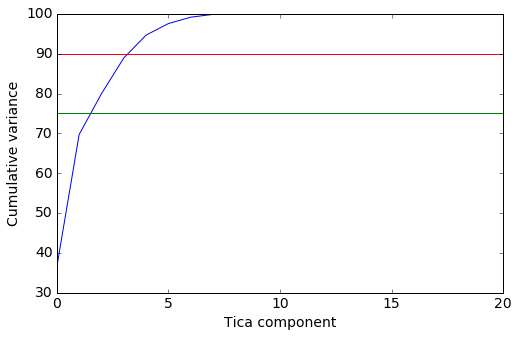

In [69]:
tica_lag=10
var_cut=75./100
tica_obj = coor.tica(inp, lag=tica_lag,var_cutoff=var_cut, kinetic_map=True)

print('TICA dimension: ', tica_obj.dimension())
print('TICA cumulative variance:')
figure(figsize(8,5))

plt.plot(tica_obj.cumvar*100)
plt.plot(np.repeat(75, 100))
plt.plot(np.repeat(90, 100))
plt.xlabel('Tica component')
plt.ylabel('Cumulative variance')
plt.xlim((0,20))

In [70]:
Y = tica_obj.get_output() # get tica coordinates
print('number of trajectories = ', np.shape(Y)[0])
print('number of frames = ', np.shape(Y)[1])
print('number of dimensions = ',np.shape(Y)[2])

('number of trajectories = ', 200)
('number of frames = ', 2000)
('number of dimensions = ', 3)


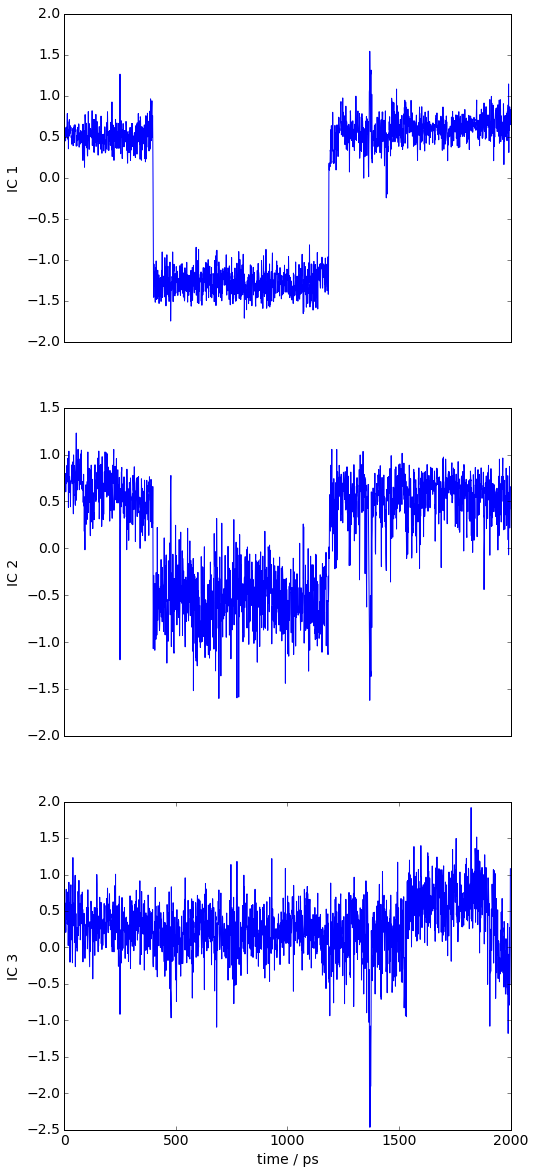

In [71]:
N = np.shape(Y)[2]
matplotlib.rcParams.update({'font.size': 14})
figure(figsize(8,20))
ax1=plt.subplot(N,1,1)
x = dt*np.arange(Y[0].shape[0])
for i in range(N-1):
    ax1=plt.subplot(N,1,i+1)
    y = Y[0][:,i] #(Y[0][:,i] - np.mean(Y[0][:,i]))/np.std(Y[0][:,i])
    plot(x, y); ylabel('IC {}'.format(i+1)); xticks([])
#     ylim((-3,3))
    
ax1=plt.subplot(N,1,N)
plot(x, Y[0][:,N-1]); xlabel('time / ps'); ylabel('IC {}'.format(N)); 

In [72]:
n_clusters = 250     # number of k-means clusters
clustering = coor.cluster_kmeans(Y,k=n_clusters, max_iter=100)

23-01-17 10:40:44 pyemma.coordinates.clustering.kmeans.KmeansClustering[29] INFO     Cluster centers converged after 28 steps.


In [73]:
dtrajs = clustering.dtrajs

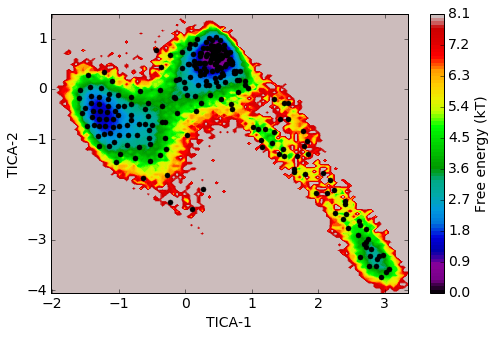

In [88]:
figure(figsize(8,5))
i, j = 0,1
mplt.plot_free_energy(np.vstack(Y)[:,i], np.vstack(Y)[:,j])
cc_x = clustering.clustercenters[:,i]
cc_y = clustering.clustercenters[:,j]
plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='black')
xlabel('TICA-1'); ylabel('TICA-2');
savefig('3states.png')

In [75]:
its = msm.timescales_msm(dtrajs, lags=np.arange(100,1000,100), nits=5)


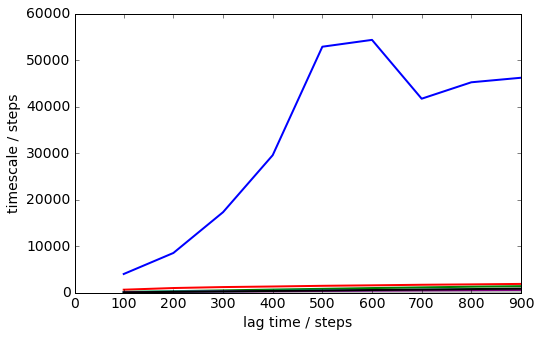

In [76]:
matplotlib.rcParams.update({'font.size': 14})
mplt.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2)
# xlim(0, 40); ylim(0, 120);

In [77]:
msm_lag = 400
M = msm.estimate_markov_model(dtrajs, msm_lag)
print('fraction of states used = ', M.active_state_fraction)
print('fraction of counts used = ', M.active_count_fraction)

('fraction of states used = ', 1.0)
('fraction of counts used = ', 1.0)


(0, 2000)

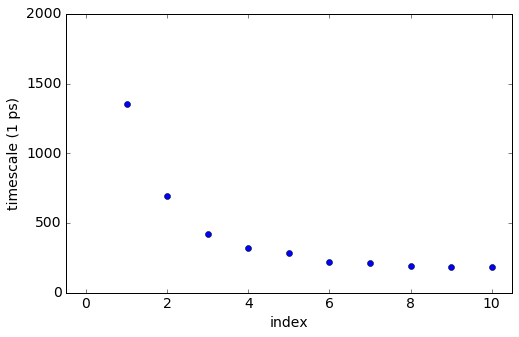

In [78]:
plot(M.timescales(),linewidth=0,marker='o')
xlabel('index'); ylabel('timescale (1 ps)'); xlim(-0.5,10.5); ylim(0,2000)

In [79]:
M.pcca(3)
pcca_dist = M.metastable_distributions
pcca_dist.shape

(3, 250)

In [80]:
pcca_samples = M.sample_by_distributions(pcca_dist, 100)


In [84]:
coor.save_traj(traj_inp=inp, indexes=pcca_samples[0], image_molecules=True, outfile='./output/dihe-pcca1_100samples.dcd')
coor.save_traj(traj_inp=inp, indexes=pcca_samples[1], image_molecules=True, outfile='./output/dihe-pcca2_100samples.dcd')
coor.save_traj(traj_inp=inp, indexes=pcca_samples[2], image_molecules=True, outfile='./output/dihe-pcca3_100samples.dcd')

ValueError: Could not find any anchor molecules. Based on our heuristic, those should be molecules with more than 57 atoms. Perhaps your topology doesn't give an acurate bond graph?